In [1]:
# Jupyter Layout
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Standard Python imports
from tempfile import NamedTemporaryFile
import os
import glob
from scipy.io import loadmat
import numpy as np
import datetime
import numpy as np

In [3]:
# PyNWB imports
from pynwb import NWBFile, get_build_manager
from pynwb.base import Module
from pynwb.misc import UnitTimes, SpikeUnit
from pynwb.ecephys import ElectrodeGroup, Device
from pynwb.epoch import EpochTimeSeries
from pynwb.image import ImageSeries
from pynwb.core import set_parents
from form.backends.hdf5 import HDF5IO

In [4]:
# Import helper function to render the HDF5 file
interactive = False

try:
    import sys
    sys.path.append('/Users/oruebel/Devel/nwb/nwb-schema/docs')
    from utils.render import NXGraphHierarchyDescription, HierarchyDescription
    if interactive:
        %matplotlib notebook
        %config InlineBackend.figure_format = 'svg'
        autostop_interact = True
    else:
        %matplotlib inline
    import matplotlib.pyplot as plt    
    VIS_AVAILABLE = True
except ImportError:
    VIS_AVAILABLE = False
    print('DISABLING VISUALIZATION OF FILE HIERARCHY')

# Notes:

This example is based on https://github.com/NeurodataWithoutBorders/api-python/blob/master/examples/create_scripts/crcns_ret-1.py from H5Gate. 

Compared to the NWB files generated by the original example we here use the extension mechanism to add custom data fields rather than adding unspecified custom data directly to the file, i.e., all objects (datasets, attributes, groups etc.) are governed by a formal specification.
* Previously pixle_size, meister_x, meister_y, meister_dx, meister_dy were stored as custom datasets in ImageSeries. Here we create an extensions MeisterImageSeries which extens ImageSeries and stores that values as attributes pixel_size, x, y, dx, dy. We here chosse attributes instead of datasets simply because these are small, single int and float metadata values for which attributes are more approbirate.

Compared to the NWB files generated by the original example the files generated here contain the following additional main changes:

* Change si_unit attribute to unit for compliance with the spec of ImageSeries 
* Moved 'source' attribute from the Module to the Interface as source is not defined in the spec for modules but only for Interface
* Added missing 'source' for SpikeUnit
* Added missing tags and description for epochs
* Added /general/devices/... to describe the device
* Added neurodata_type and namespace attributes for format compliance
* The original script reused iterator variables in nested loops. We have updated those occurance to avoid consusion and avoid possible errors. 
* The following custom metadata fields---i.e., datasets that were originally added to the file without being part of the NWB specification and without creation of corresponding extensions---have not yet been integrated with the NWB files:
    * /general custom metdata: /notes, /random_number_generation, /related_publications. This will require extension of NWBFile to extend the spec of /general. Improvements to make this easier have been proposed for discussion at the upcoming hackathon.
    * SpikeUnit custom datasets with additional copies of the per-stimulus spike times (i.e., /processing/Cells/UnitTimes/cell_*/stim_* in the original version). This will require an extension for SpikeUnit.
    * /subject, subject/genotype, subject/species : See Issue https://bitbucket.org/lblneuro/pynwb/issues/45 support for subject metadata is upcoming in PyNWB 
    * /specifications, /specifications/nwb_core.py : See Issue https://bitbucket.org/lblneuro/pynwb/issues/44 will be added by PyNWB automatically

For readability and to ease comparison, we include in Sectoin 6 the original example scrip from H5Gate. Note, the files generated by the original script are ommitting a few required datasets/attributes and as such do not actually validate. 

# Step 1: Download the Example Data

A tar file with the example data is available for download from:

https://portal.nersc.gov/project/crcns/download/nwb-1/example_script_data/source_data_2.tar.gz

Please download and uncompress the data file. 


# Step 2: Define the location of the example data

In [5]:
indata_dir = "/Volumes/Data Drive/nwb_convert_tutorial/api-python/examples/source_data_2/crcns_ret-1"

# Step 3: Define the location for the  ouput NWB file

In [6]:
output_dir = '/Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim'     # Define name of the output file. Only needed if use_temp_file=True
stim_lib_dir = os.path.join(output_dir, 'stim_lib')
if not os.path.exists(stim_lib_dir):
    os.makedirs(stim_lib_dir)

# Step 4: Reading the input data

The data read portion of this tutorial has been adapted from https://github.com/NeurodataWithoutBorders/api-python/blob/master/examples/create_scripts/crcns_ret-1.py (July 24.2017) . Large portions have been copied from that script (and modified as needed) to ease use of this example. We here seperate the data read from the data write to be illustrate which parts of the code are actually relevant for reading the input data (this section) vs. which parts are specific to the data write (see Section 5). Alternatively, we could naturally also directly read  the data to PyNWB NWBContainer classes.

## 4.1 Input data settings

In [7]:
# Create the list of file names
data_dir = os.path.join(indata_dir, 'Data')
file_list = glob.glob( data_dir + "/*.mat")

## 4.2 Read helper functions

In [8]:
def find_exp_time(fname, data_info):
    try:
        d = data_info["date"][0]
    except IndexError:
        print ("Warning: Unable to read recording date from " + fname)
        return ""
    try:
        rst = data_info["RecStartTime"][0]
    except IndexError:
        print ("Warning: Unable to read recording start time from " + fname)
        return ""
    time = d + str(rst[3]) + str(rst[4]) + str(rst[5])
    dt=datetime.datetime.strptime((time), "%Y%m%d%H%M%S")
    return dt.strftime("%a %b %d %Y %H:%M:%S")
    
def find_stim_times(fname, data_info):
    try:
        d = data_info["date"][0]
    except IndexError:
        print ("Error: Unable to read recording date from " + fname)
        assert False
    try:
        rst = data_info['RecStartTime']
    except IndexError:
        print ("Error: Unable to read recording start time from " + fname)
        assert False
    dt = []
    for i in range(len(rst)):
        time = d + str(rst[i][3]) + str(rst[i][4]) + str(rst[i][5])
        dt.append(datetime.datetime.strptime((time), "%Y%m%d%H%M%S"))
    for i in range(1,len(rst)):
        dt[i] = (dt[i] - dt[0]).total_seconds()
    dt[0] = 0.0
    return dt

def create_stim_ident(x, y, dx, dy):
    return "%dx%d_%dx%d" % (x, y, dx, dy)

def create_stimulus_file(fname, seed, x, y, dx, dy, indata_dir):
    import h5py
    print ("Creating stimulus file " + fname)
    ident = create_stim_ident(x, y, dx, dy)
    n_pixels = stim_pixel_cnt[ident]
    data = np.zeros(n_pixels)
    with open(indata_dir + "/ran1.bin", 'rb') as f:    # MODIFIED: Fix path to fit the notebook
        for i in range(int(n_pixels/8)):  #py3, added int
            byte = f.read(1)
            for j in reversed(range(8)):
                data[i*8+j] = 255*(ord(byte) >> j & 1)
            # for j in range(8):
            #     data[i*8+j] = 255 * ((ord(byte) >> (7-j)) & 1)
    nx = int(x/dx)  # py3, added int
    ny = int(y/dy)  # py3, added int
    n_frames = int(n_pixels / (nx * ny))  # py3, added int
    # reshape stimulus
    datar = np.reshape(data, (n_frames, ny, nx))
    h5 = h5py.File(fname, 'w')
    grp = h5.create_dataset("image_stack", data=datar, compression=True, dtype='uint8')
    grp.attrs["unit"] = "grayscale"
    grp.attrs["resolution"] = "1"
    grp.attrs["conversion"] = "1"
    h5.close()

def fetch_stimulus_link(seed, x, y, dx, dy, indata_dir, stim_lib_dir):
    # see if stack already exists. if not, create it
    fname = os.path.join(stim_lib_dir, "%s_%d.h5" % (create_stim_ident(x, y, dx, dy), seed))
    if not os.path.isfile(fname):
        # need to create file
        create_stimulus_file(fname, seed, x, y, dx, dy, indata_dir)
    return fname, "image_stack"

## 4.3 Create Electrode Metadata

In [9]:
channel_coordinates = []
device_name = "61-channel probe"
# using 61-channel configuration from Mesiter et al., 1994
# NOTE: this is an estimate and is used for example purposes only
for i in range(5): channel_coordinates.append([(140+70*i),   0, 0])
for i in range(6): channel_coordinates.append([(105+70*i),  60, 0])
for i in range(7): channel_coordinates.append([( 70+70*i), 120, 0])
for i in range(8): channel_coordinates.append([( 30+70*i), 180, 0])
for i in range(9): channel_coordinates.append([(    70*i), 240, 0])
for i in range(8): channel_coordinates.append([( 30+70*i), 300, 0])
for i in range(7): channel_coordinates.append([( 70+70*i), 360, 0])
for i in range(6): channel_coordinates.append([(105+70*i), 420, 0])
for i in range(5): channel_coordinates.append([(140+70*i), 480, 0])
channel_coordinates = np.asarray(channel_coordinates)   

electrode_meta = {
    'name': "61-channel_probe", 
    'channel_coordinates': channel_coordinates,
    'channel_description': ['none'] * 61,
    'channel_location': ['undefined'] * 61,
    'channel_filtering': ['undefined'] * 61,
    'channel_impedance': ['undefined'] * 61,
    'description': "Approximation of electrode array used in experiment based on Mester, et. al., 1994 (DEMO DATA)",
    'location': "Retina flatmount recording",
    'device': "----"  
}

## 4.4 Getting stimulus frame requirements

In [10]:
stim_pixel_cnt = {}
for filename in file_list:
    fname = os.path.basename(filename)
    mfile = loadmat(filename, struct_as_record=True)
    data_info = mfile['datainfo'][0,0]
    stim_offset = find_stim_times(fname, data_info)
    for i in range(len(stim_offset)):
        # create stimuli
        # read data from mat file
        stimulus = mfile["stimulus"][0,i]
        n_frames = stimulus["Nframes"][0,0]
        # figure out how many pixels per frame
        x = stimulus["param"]["x"][0,0][0,0]
        y = stimulus["param"]["y"][0,0][0,0]
        dx = stimulus["param"]["dx"][0,0][0,0]
        dy = stimulus["param"]["dy"][0,0][0,0]
        nx = int(x/dx)
        ny = int(y/dy)
        n_pix = n_frames * nx * ny
        # remember maximum pixel count for this stimulus type
        name = create_stim_ident(x, y, dx, dy)
        if name in stim_pixel_cnt:
            n = stim_pixel_cnt[name]
            if n_pix > n:
                stim_pixel_cnt[name] = n_pix
        else:
            stim_pixel_cnt[name] = n_pix

## 4.5 Read file metadata, spike data, and stimulus data

In [11]:
# The following dicts use filenames as keys and store for each file a dict with the 
# associated file metadta, stimulus data, and spike data, respectively
per_file_meta = {}              # File metadata : Store for each file a single dict with the metadata about that file 
stimulus_data = {}          # Stimulus data : Store for each file a list of dicts with the metadata about all stimuli
spike_unit_times_data = {}  # Spike data : Store for each file a list of dicts with the metadata about the SpikeUnits in UnitTimes

for filename in file_list:
    print("Processing: %s" % filename)
    fname = os.path.basename(filename)
    mfile = loadmat(filename, struct_as_record=True)
    data_info = mfile['datainfo'][0,0]
    stim_offset = find_stim_times(fname, data_info)
    
    ##################################
    #  Read file metadata
    ##################################
    rec_no = data_info["RecNo"][0]
    smpl_no = data_info["SmplNo"][0]
    animal = str(data_info["animal"][0])
    notes = str(data_info["description"][0])
    session_id = "RecNo: " + str(rec_no) + "; SmplNo: " + str(smpl_no)
    per_file_meta[filename] =  {
        "output_filename": os.path.join(output_dir, "%s.nwb" % str(fname[:-4])),
        "start_time": find_exp_time(os.path.basename(file_list[0]), data_info),
        "identifier": "Meister test data",
        "description": "Optical stimulation and extracellular recording of retina",
        "create_date": datetime.datetime.now(),
        "experimenter": "Yifeng Zhang",                       
        "experiment_description": None,
        "session_id": "RecNo: " + str(rec_no) + "; SmplNo: " + str(smpl_no),
        "institution": "Harvard University",
        "lab": "Markus Meister",
        "related_publications": "Yi-Feng Zhang, Hiroki Asari, and Markus Meister (2014); Multi-electrode recordings from retinal ganglion cells. CRCNS.org. http://dx.doi.org/10.6080/K0RF5RZT",
        "notes": notes,
        "species": "mouse",
        "genotype": animal
    }   
    
    ###################################################
    #  Read stimulus presentation image series data
    ###################################################
    stim_offsets = find_stim_times(fname, data_info)
    curr_stim_data = []
    # get stimulus offset times
    for i in range(len(stim_offsets)):
        stim_dat = {
            "file": filename,
            "index": i,
            "offset": stim_offsets[i]
        }
        # create stimuli
        # read data from mat file
        stimulus = mfile["stimulus"][0,i]
        stim_dat['n_frames'] = stimulus["Nframes"][0,0]
        stim_dat['frame'] = stimulus["frame"][0,0]
        stim_dat['onset'] = stimulus["onset"][0,0]
        stim_dat['type_s'] = stimulus["type"][0]
        stim_dat['seed'] = stimulus["param"]["seed"][0,0][0,0]
        stim_dat['x'] = stimulus["param"]["x"][0,0][0,0]
        stim_dat['y'] = stimulus["param"]["y"][0,0][0,0]
        stim_dat['dx'] = stimulus["param"]["dx"][0,0][0,0]
        stim_dat['dy'] = stimulus["param"]["dy"][0,0][0,0]
        stim_dat['pixel_size'] = stimulus["pixelsize"][0,0]
        stim_dat['timestamps'] = np.arange(stim_dat['n_frames']) * stim_dat['frame']  + stim_dat['onset'] + stim_dat['offset']
        stim_dat['end'] = 1.
        if stim_dat['timestamps'].size>0:
            stim_dat['end'] += stim_dat['timestamps'][-1] 
        stim_dat['rec_stim_name'] = "rec_stim_%d" % (i+1)
        stim_dat['description'] = "type = %s; seed = %s" % (str(stim_dat['type_s']), str(stim_dat['seed']))
        stim_dat['dimension'] = [int(stim_dat['x']/stim_dat['dx']), 
                                 int(stim_dat['y']/stim_dat['dy'])]
        stim_dat['data'] = fetch_stimulus_link(seed=stim_dat['seed'], 
                                               x=stim_dat['x'], 
                                               y=stim_dat['y'], 
                                               dx=stim_dat['dx'], 
                                               dy=stim_dat['dy'],
                                               indata_dir=indata_dir,
                                               stim_lib_dir=stim_lib_dir)
        curr_stim_data.append(stim_dat)
    stimulus_data[filename] = curr_stim_data
    
    ###########################################
    #  Read the spike data
    ############################################
    spikes_mat = mfile["spikes"]
    num_cells = spikes_mat.shape[0]
    num_stims =  spikes_mat.shape[1]
    spike_units = []
    for cell_index in range(num_cells):
        curr_spike_unit = {
            'name': "cell_%d" %(cell_index+1),
            'custom_stim_spikes': {}
        }
        spike_list = []
        for j in range(num_stims):
           
            stim_name = "stim_%d" % (j+1)
            spikes = np.hstack(spikes_mat[cell_index,j]) + stim_offsets [j]
            spike_list.extend(spikes)
            curr_spike_unit['custom_stim_spikes'][stim_name] = spikes
            
        curr_spike_unit['times'] = spike_list
        curr_spike_unit['unit_description'] = 'none'  # This was also 'none' in the original version 
        curr_spike_unit['source'] = "Data as reported in the original crcns file"
        spike_units.append(curr_spike_unit)
    
    spike_unit_times_data[filename] = spike_units
    

Processing: /Volumes/Data Drive/nwb_convert_tutorial/api-python/examples/source_data_2/crcns_ret-1/Data/20080516_R1.mat
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim/stim_lib/640x480_1x480_-10000.h5
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim/stim_lib/640x480_10x10_-10000.h5
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim/stim_lib/640x480_640x1_-10000.h5
Processing: /Volumes/Data Drive/nwb_convert_tutorial/api-python/examples/source_data_2/crcns_ret-1/Data/20080516_R2.mat
Processing: /Volumes/Data Drive/nwb_convert_tutorial/api-python/examples/source_data_2/crcns_ret-1/Data/20080606_R1.mat
Processing: /Volumes/Data Drive/nwb_convert_tutorial/api-python/examples/source_data_2/crcns_ret-1/Data/20080606_R2.mat
Processing: /Volumes/Data Drive/nwb_convert_tutorial/api-python/examples/source_data_2/crcns_ret-1/Data/20080606_R3.mat
Process

# Step 5: Creating the NWB data using PyNWB

## Step 5.1: Create extensions for storing custom metadata

In [12]:
from pynwb.spec import NWBNamespaceBuilder, NWBGroupSpec, NWBAttributeSpec, NWBDatasetSpec
from pynwb import get_class, load_namespaces

# Define where our extensions should be stored
ext_output_dir  = os.path.join(output_dir, "extensions")
ns_name = 'crcnsret1'
ns_path  = os.path.join(ext_output_dir, '%s.namespace.yaml' % ns_name)
ext_path = '%s.extensions.yaml' % ns_name

# Check to make sure that our storage location for the extensions exists
if not os.path.exists(ext_output_dir):
    os.makedirs(ext_output_dir)

# Build the namespace
ns_builder = NWBNamespaceBuilder('Extension for use in my Lab', ns_name)

# Create a custom ImageSeries to add our custom attributes and add our extenions to the namespace
mis_ext = NWBGroupSpec('A custom ImageSeries to add MeisterLab custom metadata',
                       attributes=[NWBAttributeSpec('x' , 'int', 'meister x', required=False),
                                   NWBAttributeSpec('y' , 'int', 'meister y', required=False),
                                   NWBAttributeSpec('dx', 'int', 'meister dx', required=False),
                                   NWBAttributeSpec('dy', 'int', 'meister dy', required=False),
                                   NWBAttributeSpec('pixel_size', 'float', 'meister pixel size', required=False)],
                       neurodata_type_inc='ImageSeries',
                       neurodata_type_def='MeisterImageSeries') 
ns_builder.add_spec(ext_path, mis_ext)

# Export the YAML files for our namespace and extensions
ns_builder.export(ns_path)

# Load the namespace to register it with PyNWB
load_namespaces(ns_path)

In [13]:
# Get our custom container classes for our extensions
MeisterImageSeries = get_class('MeisterImageSeries', ns_name) 

We can now inspect our container class using the usual mechanisms, e.g., help. For illustration purposes, let's call help on our class. Here we can see that:
* Our custom attributes have been added to the constructor with approbriate documention describing the type and purpose we indicated in the spec for our attributes
* From the "Method resolution order" documentationw we can see that our MeisterImageSeries inherits from pynwb.image.ImageSeries so that interaction mechanims from the base class are also available in our class

In [14]:
help(MeisterImageSeries)

Help on class MeisterImageSeries in module abc:

class MeisterImageSeries(pynwb.image.ImageSeries)
 |  General image data that is common between acquisition and stimulus time series.
 |  The image data can be stored in the HDF5 file or it will be stored as an external image file.
 |  
 |  Method resolution order:
 |      MeisterImageSeries
 |      pynwb.image.ImageSeries
 |      pynwb.base.TimeSeries
 |      pynwb.core.NWBContainer
 |      form.container.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(*args, **kwargs)
 |      __init__(name, source, data, unit, format, external_file=None, starting_frame=None, bits_per_pixel=None, dimension=[nan], resolution=0.0, conversion=1.0, timestamps=None, starting_time=None, rate=None, comments=None, description=None, control=None, control_description=None, parent=None, dx=None, x=None, dy=None, pixel_size=None, y=None)
 |      
 |      
 |      
 |      Args:
 |          name (str): The name of this TimeSeries d

For illustration purposes, let's also have a quick look at the contents of our YAML namespace and extension file.

In [15]:
print(os.path.basename(ns_path))
print("------------------------")
with open(ns_path, 'r') as fin:
    print(fin.read())
print("")
print(ext_path)
print("-------------------------")
with open(os.path.join(ext_output_dir, ext_path), 'r') as fin:
    print(fin.read())

crcnsret1.namespace.yaml
------------------------
namespaces:
- doc: Extension for use in my Lab
  name: crcnsret1
  schema:
  - namespace: core
  - source: crcnsret1.extensions.yaml


crcnsret1.extensions.yaml
-------------------------
groups:
- attributes:
  - doc: meister x
    dtype: int
    name: x
    required: false
  - doc: meister y
    dtype: int
    name: y
    required: false
  - doc: meister dx
    dtype: int
    name: dx
    required: false
  - doc: meister dy
    dtype: int
    name: dy
    required: false
  - doc: meister pixel size
    dtype: float
    name: pixel_size
    required: false
  doc: A custom ImageSeries to add MeisterLab custom metadata
  neurodata_type_def: MeisterImageSeries
  neurodata_type_inc: ImageSeries



## Step 5.2: Write Single NWB file

This example generates a series of NWB HDF5 files. We here define first a function to convert a single file.

In [16]:
def convert_single_file(file_stimulus_data, file_meta, spike_units, electrode_meta):
    import h5py
    #########################################
    # Create the NWBFile containter
    ##########################################
    nwbfile = NWBFile(file_name=file_meta['output_filename'],
                      session_description=file_meta['description'],
                      identifier=file_meta['identifier'],
                      session_start_time=file_meta['start_time'],
                      file_create_date=file_meta['create_date'],
                      experimenter=file_meta['experimenter'],
                      experiment_description=file_meta['experiment_description'],
                      session_id=file_meta['session_id'],
                      institution=file_meta['institution'],
                      lab=file_meta['lab'])
    
    ################################################
    # Convert the stimuls data for the file
    ################################################
    for i, curr_stimulus in enumerate(file_stimulus_data):
        
        ####################################################
        # Get the external dataset with the stimulus data
        ####################################################
        # To create an external link to the HDF5 dataset from our stimulus library we simply get the dataset
        # and assign it to the data input parameter of our ImageSeries (i.e., here our extension MeisterImageSeries).
        # PyNWB recognizes the h5py.Dataset and automatically creates an ExternalLink or SoftLink for the 
        # data, depending on whether the data comes from the same file or an external HDF5 file. 
        stim_data_file = h5py.File(curr_stimulus['data'][0], 'r')
        stim_ext_data = stim_data_file[curr_stimulus['data'][1]]
        
        #####################################################
        # Create the image timeseries for the stimulus
        #####################################################
        img = MeisterImageSeries(name=curr_stimulus['rec_stim_name'],  # The following are inherited from ImageSeries
                                 source='Undefined',
                                 data=stim_ext_data, # By assigning the existing HDF5 dataset from the external file, PyNWB automatically creates an ExternalLink for data
                                 unit="grayscale",
                                 format='raw',
                                 bits_per_pixel=8,
                                 dimension=curr_stimulus['dimension'],
                                 timestamps=curr_stimulus['timestamps'],
                                 description=curr_stimulus['description'],  
                                 x=int(curr_stimulus['x']),   # The following are custom attribute values we added to our MeiterImageSeries extension
                                 y=int(curr_stimulus['y']),
                                 dx=int(curr_stimulus['dx']),
                                 dy=int(curr_stimulus['dy']),
                                 pixel_size=curr_stimulus['pixel_size'],
                             )
        nwbfile.add_stimulus(img)  # Add the stimulus timeseries to the file
        
        ##############################################
        # Create the epoch for the stimulus
        ##############################################    
        epoch = nwbfile.create_epoch(name="stim_%d"%(i+1), 
                                     start=curr_stimulus['offset'],
                                     stop=curr_stimulus['end'],
                                     tags=[],
                                     description="")
        # Create the EpochTimeSeries
        epoch.add_timeseries(timeseries=img,
                             in_epoch_name="stimulus")
            
    
    ####################################################################################################
    #  Create the module 'Cells' with a single 'UnitTimes' interfaces storing a set of 'SpikeUnites'
    #####################################################################################################
    cells_module = nwbfile.create_processing_module(name="Cells", 
                                                    description="Spike times for the individual cells and stimuli")
    spike_unit_objs = []
    for spike_unit_data in spike_units:
        spike_unit_objs.append(SpikeUnit(name=spike_unit_data['name'],
                                         times=spike_unit_data['times'],
                                         unit_description=spike_unit_data['unit_description'],
                                         source=spike_unit_data['source']))
        # TODO Add custom data'custom_stim_spikes' data to the SpikeUnit
    unit_times = UnitTimes(source="Data as reported in the original crcns file",
                           spike_units=spike_unit_objs)
    for i in spike_unit_objs:
        i.parent = unit_times
    cells_module.add_interface(unit_times)
    
    #####################################################
    # Create the electrode group
    #####################################################
    device = nwbfile.create_device(electrode_meta['device'])
    electrode_group = nwbfile.create_electrode_group(name=electrode_meta['name'],
                                                     channel_coordinates=electrode_meta['channel_coordinates'],
                                                     channel_description=electrode_meta['channel_description'],
                                                     channel_location=electrode_meta['channel_location'],
                                                     channel_filtering=electrode_meta['channel_filtering'],
                                                     channel_impedance=electrode_meta['channel_impedance'],
                                                     description=electrode_meta['description'],
                                                     location=electrode_meta['location'],
                                                     device=device)
    
    # TODO Add metadata
    # file_meta['related_publications']
    # file_meta['notes']
    # file_meta['species'] 
    # file_meta['genotype']
    
    ##################################
    # Write the NWB file
    ##################################
    manager = get_build_manager()
    io = HDF5IO(nwbfile.filename, manager)
    io.write(nwbfile)
    stim_data_file.close()

## Step 5.3: Convert all files

Convert all the files by iteating over the files and calling `convert_single_file` function for each of the file

In [17]:
for filename in file_list:
    convert_single_file(file_stimulus_data=stimulus_data[filename],
                        file_meta=per_file_meta[filename], 
                        spike_units=spike_unit_times_data[filename], 
                        electrode_meta=electrode_meta)

# 6 Run the convert script from H5Gate

For illustration purposes, we here also perform the same convert using the orginal H5Gate API. This allows us to compare our updated NWB files with the v1.0.5bNWB files generated.

In [18]:
h5gate_path = '/Volumes/Data Drive/nwb_convert_tutorial/api-python'
h5gate_output_dir = os.path.join(output_dir, 'nwb_v1.0.5b/')
sys.path.append(h5gate_path)
run_h5gate_convert = not os.path.exists(h5gate_output_dir)

The following is a copy of the following script: https://github.com/NeurodataWithoutBorders/api-python/blob/master/examples/create_scripts/crcns_ret-1.py . Minor modifications were made to paths to make the script work within the notebook indicated by `#MODIFIED` comments. The script is included here to ease comparison and use of the example.

In [19]:
if run_h5gate_convert:   # MODIFIED: Added outer if to allow us to avoid running the script again
    #!/usr/bin/python

    # script to convert Meister sample data sets to NWB format
    # modified to use specification language

    import glob
    import sys
    import os
    import h5py
    import datetime
    import numpy as np
    import scipy.io as sio

    from nwb import nwb_file
    from nwb import nwb_utils as ut


    # directory for input data
    SOURCE_DATA_DIR = indata_dir  # MODIFIED: Set to our current input data dir
    path = SOURCE_DATA_DIR + "/Data/"  # MODIFIED: Fix path to fit the notebook

    if not os.path.exists(path):
        # print ("Source files for script '%s' not present." % os.path.basename(__file__))  # MODIFIED: Removed Print
        print ("Download and put them in the 'examples/source_data' directory as instructed")
        print ("in file examples/0_README.txt")
        # sys.exit(1)   # MODIFIED: Do not exit


    file_list = glob.glob(path + "*.mat")
    #file_list = [path+"20080516_R2.mat"]

    if not file_list:
        print ("*** Error:")
        print ("No files found at '%s'.  Cannot run script %s." % (path, os.path.basename(__file__)))
        sys.exit(1)

    # directory for created NWB files.  Must have a trailing slash.
    OUTPUT_DIR = h5gate_output_dir      # MODIFIED: Use our own output directory
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    # this directory for storing generated stimulus files (which are not NWB files).
    STIM_LIBRARY_DIR = OUTPUT_DIR + "stim_library/"
    if not os.path.exists(STIM_LIBRARY_DIR):
        os.makedirs(STIM_LIBRARY_DIR)


    def find_exp_time(fname, data_info):
        try:
            d = data_info["date"][0]
        except IndexError:
            print ("Warning: Unable to read recording date from " + fname)
            return ""
        try:
            rst = data_info["RecStartTime"][0]
        except IndexError:
            print ("Warning: Unable to read recording start time from " + fname)
            return ""
        time = d + str(rst[3]) + str(rst[4]) + str(rst[5])
        dt=datetime.datetime.strptime((time), "%Y%m%d%H%M%S")
        return dt.strftime("%a %b %d %Y %H:%M:%S")

    def find_stim_times(fname, data_info):
        try:
            d = data_info["date"][0]
        except IndexError:
            print ("Error: Unable to read recording date from " + fname)
            assert False
        try:
            rst = data_info['RecStartTime']
        except IndexError:
            print ("Error: Unable to read recording start time from " + fname)
            assert False
        dt = []
        for i in range(len(rst)):
            time = d + str(rst[i][3]) + str(rst[i][4]) + str(rst[i][5])
            dt.append(datetime.datetime.strptime((time), "%Y%m%d%H%M%S"))
        for i in range(1,len(rst)):
            dt[i] = (dt[i] - dt[0]).total_seconds()
        dt[0] = 0.0
        return dt

    def create_stim_ident(x, y, dx, dy):
        return "%dx%d_%dx%d" % (x, y, dx, dy)

    def create_stimulus_file(fname, seed, x, y, dx, dy):
        print ("Creating stimulus file " + fname)
        ident = create_stim_ident(x, y, dx, dy)
        n_pixels = stim_pixel_cnt[ident]
        data = np.zeros(n_pixels)
        with open(SOURCE_DATA_DIR + "/ran1.bin", 'rb') as f:    # MODIFIED: Fix path to fit the notebook
            for i in range(int(n_pixels/8)):  #py3, added int
                byte = f.read(1)
                for j in reversed(range(8)):
                    data[i*8+j] = 255*(ord(byte) >> j & 1)
                # for j in range(8):
                #     data[i*8+j] = 255 * ((ord(byte) >> (7-j)) & 1)
        nx = int(x/dx)  # py3, added int
        ny = int(y/dy)  # py3, added int
        n_frames = int(n_pixels / (nx * ny))  # py3, added int
        # reshape stimulus
        datar = np.reshape(data, (n_frames, ny, nx))
        h5 = h5py.File(fname, 'w')
        grp = h5.create_dataset("image_stack", data=datar, compression=True, dtype='uint8')
        grp.attrs["si_unit"] = "grayscale"
        grp.attrs["resolution"] = "1"
        grp.attrs["conversion"] = "1"
        h5.close()

    def fetch_stimulus_link(seed, x, y, dx, dy):
        # see if stack already exists. if not, create it
        fname = STIM_LIBRARY_DIR + "%s_%d.h5" % (create_stim_ident(x, y, dx, dy), seed)
        if not os.path.isfile(fname):
            # need to create file
            create_stimulus_file(fname, seed, x, y, dx, dy)
        return fname, "image_stack"


    electrode_map = []
    # using 61-channel configuration from Mesiter et al., 1994
    # NOTE: this is an estimate and is used for example purposes only
    for i in range(5): electrode_map.append([(140+70*i),   0, 0])
    for i in range(6): electrode_map.append([(105+70*i),  60, 0])
    for i in range(7): electrode_map.append([( 70+70*i), 120, 0])
    for i in range(8): electrode_map.append([( 30+70*i), 180, 0])
    for i in range(9): electrode_map.append([(    70*i), 240, 0])
    for i in range(8): electrode_map.append([( 30+70*i), 300, 0])
    for i in range(7): electrode_map.append([( 70+70*i), 360, 0])
    for i in range(6): electrode_map.append([(105+70*i), 420, 0])
    for i in range(5): electrode_map.append([(140+70*i), 480, 0])
    electrode_group = []
    for i in range(len(electrode_map)):
        electrode_group.append("61-channel probe")

    print ("Getting stimulus frame requirements")
    stim_pixel_cnt = {}
    for i in range(len(file_list)):
        fname = file_list[i][len(path):]
        mfile = sio.loadmat(file_list[i], struct_as_record=True)
        # prepare matlab data
        data_info = mfile['datainfo'][0,0]
        # 
        stim_offset = find_stim_times(fname, data_info)
        for i in range(len(stim_offset)):
            # create stimuli
            # read data from mat file
            stimulus = mfile["stimulus"][0,i]
            n_frames = stimulus["Nframes"][0,0]
            # figure out how many pixels per frame
            x = stimulus["param"]["x"][0,0][0,0]
            y = stimulus["param"]["y"][0,0][0,0]
            dx = stimulus["param"]["dx"][0,0][0,0]
            dy = stimulus["param"]["dy"][0,0][0,0]
            nx = int(x/dx)
            ny = int(y/dy)
            n_pix = n_frames * nx * ny
            # remember maximum pixel count for this stimulus type
            name = create_stim_ident(x, y, dx, dy)
            if name in stim_pixel_cnt:
                n = stim_pixel_cnt[name]
                if n_pix > n:
                    stim_pixel_cnt[name] = n_pix
            else:
                stim_pixel_cnt[name] = n_pix

    for i in range(len(file_list)):
        fname = file_list[i][len(path):]
        print ("Processing " + fname)
        mfile = sio.loadmat(file_list[i], struct_as_record=True)
        # prepare matlab data
        data_info = mfile['datainfo'][0,0]
        # prepare output file
        vargs = {}
        vargs["start_time"] = find_exp_time(fname, data_info)
        vargs["identifier"] = ut.create_identifier("Meister test data")
        vargs["mode"] = "w"
        vargs["description"] ="Optical stimulation and extracellular recording of retina"
        vargs["file_name"] = OUTPUT_DIR + fname[:-4]+".nwb"    
        bfile = nwb_file.open(**vargs)
        print ("Creating " + vargs["file_name"])
        # get stimulus offset times
        stim_offset = find_stim_times(fname, data_info)
        stim_end = []
        # 
        for i in range(len(stim_offset)):
            # create stimuli
            # read data from mat file
            stimulus = mfile["stimulus"][0,i]
            n_frames = stimulus["Nframes"][0,0]
            frame = stimulus["frame"][0,0]
            onset = stimulus["onset"][0,0]
            type_s = stimulus["type"][0]
            seed = stimulus["param"]["seed"][0,0][0,0]
            x = stimulus["param"]["x"][0,0][0,0]
            y = stimulus["param"]["y"][0,0][0,0]
            dx = stimulus["param"]["dx"][0,0][0,0]
            dy = stimulus["param"]["dy"][0,0][0,0]
            pixel_size = stimulus["pixelsize"][0,0]
            # reformmat for nwb
            timestamps = np.arange(n_frames) * frame + onset + stim_offset[i]
            rec_stim_name = "rec_stim_%d" % (i+1)
            # create stimulus
            img = bfile.make_group("<ImageSeries>", rec_stim_name, path="/stimulus/presentation")
            img.set_custom_dataset("pixel_size", pixel_size)
            img.set_custom_dataset("meister_dx", dx)
            img.set_custom_dataset("meister_dy", dy)
            img.set_custom_dataset("meister_x", x)
            img.set_custom_dataset("meister_y", y)
            img.set_dataset("timestamps", timestamps)
            img.set_dataset("num_samples", len(timestamps))
            file_name, dataset_name = fetch_stimulus_link(seed, x, y, dx, dy)
            file_name_base = file_name[len(OUTPUT_DIR):]  # strip OUTPUT_DIR from front of name
            #- img.set_data_as_remote_link(file_name, dataset_name)
            link_str = "extlink:%s,%s" % (file_name_base, dataset_name)
            img.set_dataset("data", link_str) # special string, causes creation of external link
            img.set_dataset("bits_per_pixel", 8)
            img.set_dataset("format", "raw")
            img.set_dataset("dimension", [int(x/dx), int(y/dy)])  # py3, force to be int
            img.set_attr("description", "type = " + str(type_s) + "; seed = " + str(seed))
            img.set_attr("comments", "Based on ran1.bin. Pixel values are 255 for light, 0 for dark")
            # create epoch
            stim_end = timestamps[-1] + 1
            epoch = ut.create_epoch(bfile, "stim_%d"%(i+1), stim_offset[i], stim_end)
            stim_start = stim_offset[i]
            ts_path = "/stimulus/presentation/"+img.name
            ut.add_epoch_ts(epoch, stim_start, stim_end, "stimulus", ts_path)

        # create module 'Cells' for the spikes    
        mod_name = "Cells"
        mod = bfile.make_group("<Module>", mod_name)
        mod.set_attr("description", "Spike times for the individual cells and stimuli")
        mod.set_attr("source", "Data as reported in the original file")
        # create interfaces
        spk_times_iface = mod.make_group("UnitTimes")
        spk_times_iface.set_attr("source", "Data as reported in the original crcns file")
        # determine number of cells
        spikes_mat = mfile["spikes"]
        num_cells = spikes_mat.shape[0]
        num_stims = spikes_mat.shape[1]
        # unit_list = []  ## Added for specification language conversion method
        for i in range(num_cells):
            cell_name = "cell_%d" %(i+1)
            # unit_list.append(cell_name)   ## Added for specification language conversion method
            cgrp = spk_times_iface.make_group("<unit_N>", cell_name)
            spike_list = []
            for j in range(num_stims):
                stim_name = "stim_%d" % (j+1)
                spikes = np.hstack(spikes_mat[i,j]) + stim_offset[j]
                spike_list.extend(spikes)
                cgrp.set_custom_dataset(stim_name, spikes)
            cgrp.set_dataset("times", spike_list)
            cgrp.set_dataset("unit_description", "none")       
        #- spk_times_iface.finalize()
        # spk_times_iface.set_dataset("unit_list", unit_list) ## Added for specification language conversion method
        #- mod.finalize()

        # write metadata
        rec_no = data_info["RecNo"][0]
        smpl_no = data_info["SmplNo"][0]
        animal = data_info["animal"][0]
        description = data_info["description"][0]
        session_id = "RecNo: " + str(rec_no) + "; SmplNo: " + str(smpl_no)
        bfile.set_dataset("session_id", session_id)
        bfile.set_dataset("experimenter", "Yifeng Zhang")    
        bfile.set_dataset("institution", "Harvard University")
        bfile.set_dataset("lab", "Markus Meister")
        bfile.set_dataset("related_publications", "Yi-Feng Zhang, Hiroki Asari, and Markus Meister (2014); Multi-electrode recordings from retinal ganglion cells. CRCNS.org. http://dx.doi.org/10.6080/K0RF5RZT")
        bfile.set_dataset("notes", str(description))
        bfile.set_dataset("species", "mouse")
        bfile.set_dataset("genotype", str(animal))
        bfile.set_custom_dataset("random_number_generation", "Reference: WH Press, et al. (1992) Numerical Recipes in C, 2nd ed.")
        # bfile.set_custom_metadata_by_file("random_number_generation_code", "ran1.m")
        bfile.set_dataset('electrode_map', electrode_map)
        bfile.set_dataset('electrode_group', electrode_group)
        g =  bfile.make_group('<electrode_group_X>', "61-channel_probe")
        g.set_dataset('description',"Approximation of electrode array used in experiment based on Mester, et. al., 1994 (DEMO DATA)")
        g.set_dataset('location',"Retina flatmount recording")
        g.set_dataset('device', "----")
        print ("\tdone")
        bfile.close()

Getting stimulus frame requirements
Processing 20080516_R1.mat
Creating /Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim/nwb_v1.0.5b/20080516_R1.nwb
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim/nwb_v1.0.5b/stim_library/640x480_1x480_-10000.h5
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim/nwb_v1.0.5b/stim_library/640x480_10x10_-10000.h5
Creating stimulus file /Volumes/Data Drive/nwb_convert_tutorial/convert_test/crcns-ret-1-ext-stim/nwb_v1.0.5b/stim_library/640x480_640x1_-10000.h5
	done

******
Validation messages follow.
** 5 errors.
No Miscellaneous errors. -- Good
No groups missing. -- Good
2 datasets missing:
  1. '/general/extracellular_ephys/filtering'
  2. '/general/extracellular_ephys/impedance'
3 attributes missing (1 combined):
  1. /stimulus/presentation/rec_stim_# - source (#=1-3)
No Incorrect attribute values. -- Good
No groups custom missing at

# 7 Basic Validation and Visualization

In [20]:
example_file = '20080516_R1.nwb'  # Pick one file for illustration purposes to compare the file generated by H5Gate and PyNWB
pynwb_example_file = os.path.join(output_dir, example_file)
h5gate_example_file = os.path.join(h5gate_output_dir, example_file)

In [21]:
f1 = HierarchyDescription.from_hdf5(pynwb_example_file)
f2 = HierarchyDescription.from_hdf5(h5gate_example_file)

# Compare groups
g1= set([i['name'] for i in f1['groups']])
g2= set([i['name'] for i in f2['groups']])
print("Groups in H5Gate file not in PyNWB file")
for i in (g2-g1):
    print(i)
print("")
print("Groups in PyNWB file not in H5Gate file")
for i in (g1-g2):
    print(i)    

# Compare datasets    
d1= set([i['name'] for i in f1['datasets']])
d2= set([i['name'] for i in f2['datasets']])
print("")
print("Datasets in H5Gate file not in PyNWB file")
for i in sorted(d2-d1):
    print(i)
print("")
print("Datasets in PyNWB file not in H5Gate file")
for i in sorted(d1-d2):
    print(i)    

# Compare attributes    
a1= set([i['name'] for i in f1['attributes']])
a2= set([i['name'] for i in f2['attributes']])
# Omitted attributes refer to attributes on omitted datasets 
#for i in sorted(a2-a1):
#    print(i)
print("")
print("Attributes in PyNWB file not in H5Gate file")
for i in sorted(a1-a2):
    print(i)

Groups in H5Gate file not in PyNWB file
/general/subject
/general/specifications

Groups in PyNWB file not in H5Gate file
/general/devices
/general/devices/----

Datasets in H5Gate file not in PyNWB file
/general/extracellular_ephys/61-channel_probe/device
/general/extracellular_ephys/electrode_group
/general/extracellular_ephys/electrode_map
/general/notes
/general/random_number_generation
/general/related_publications
/general/specifications/nwb_core.py
/general/subject/genotype
/general/subject/species
/processing/Cells/UnitTimes/cell_1/stim_1
/processing/Cells/UnitTimes/cell_1/stim_2
/processing/Cells/UnitTimes/cell_1/stim_3
/processing/Cells/UnitTimes/cell_2/stim_1
/processing/Cells/UnitTimes/cell_2/stim_2
/processing/Cells/UnitTimes/cell_2/stim_3
/processing/Cells/UnitTimes/cell_3/stim_1
/processing/Cells/UnitTimes/cell_3/stim_2
/processing/Cells/UnitTimes/cell_3/stim_3
/processing/Cells/UnitTimes/cell_4/stim_1
/processing/Cells/UnitTimes/cell_4/stim_2
/processing/Cells/UnitTimes

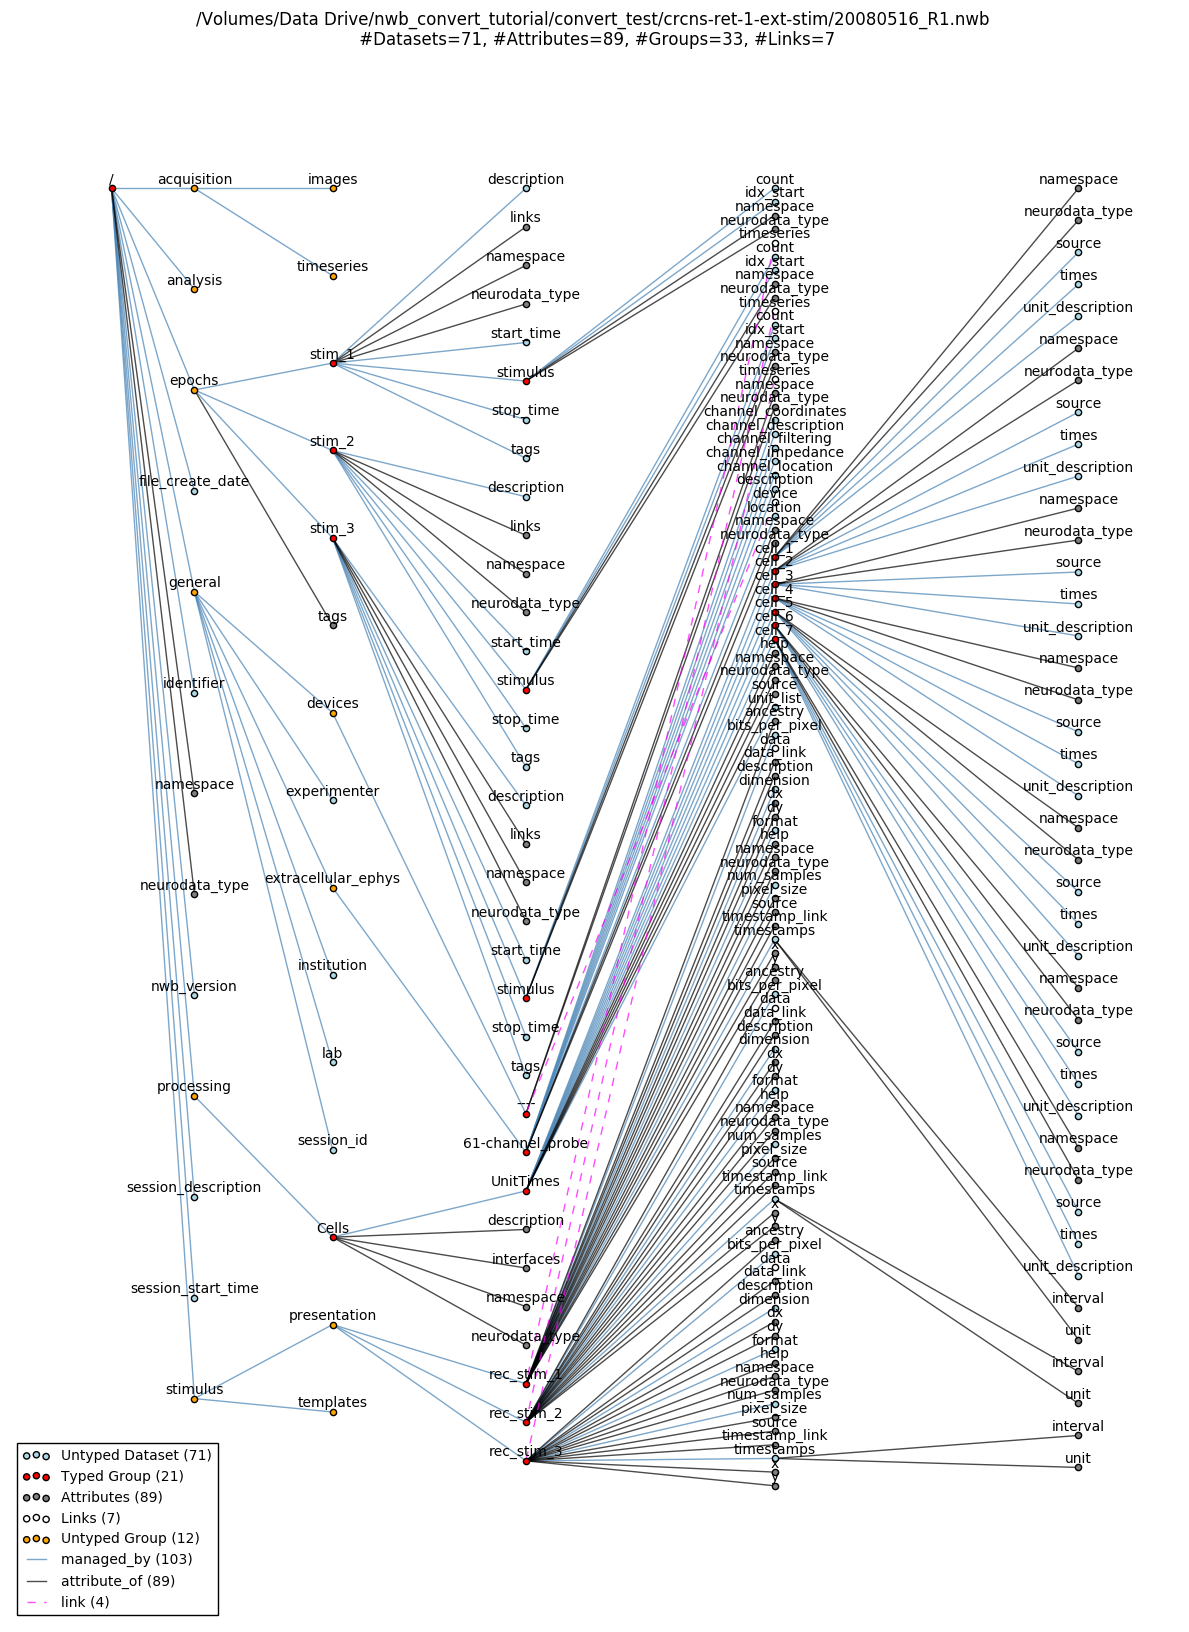

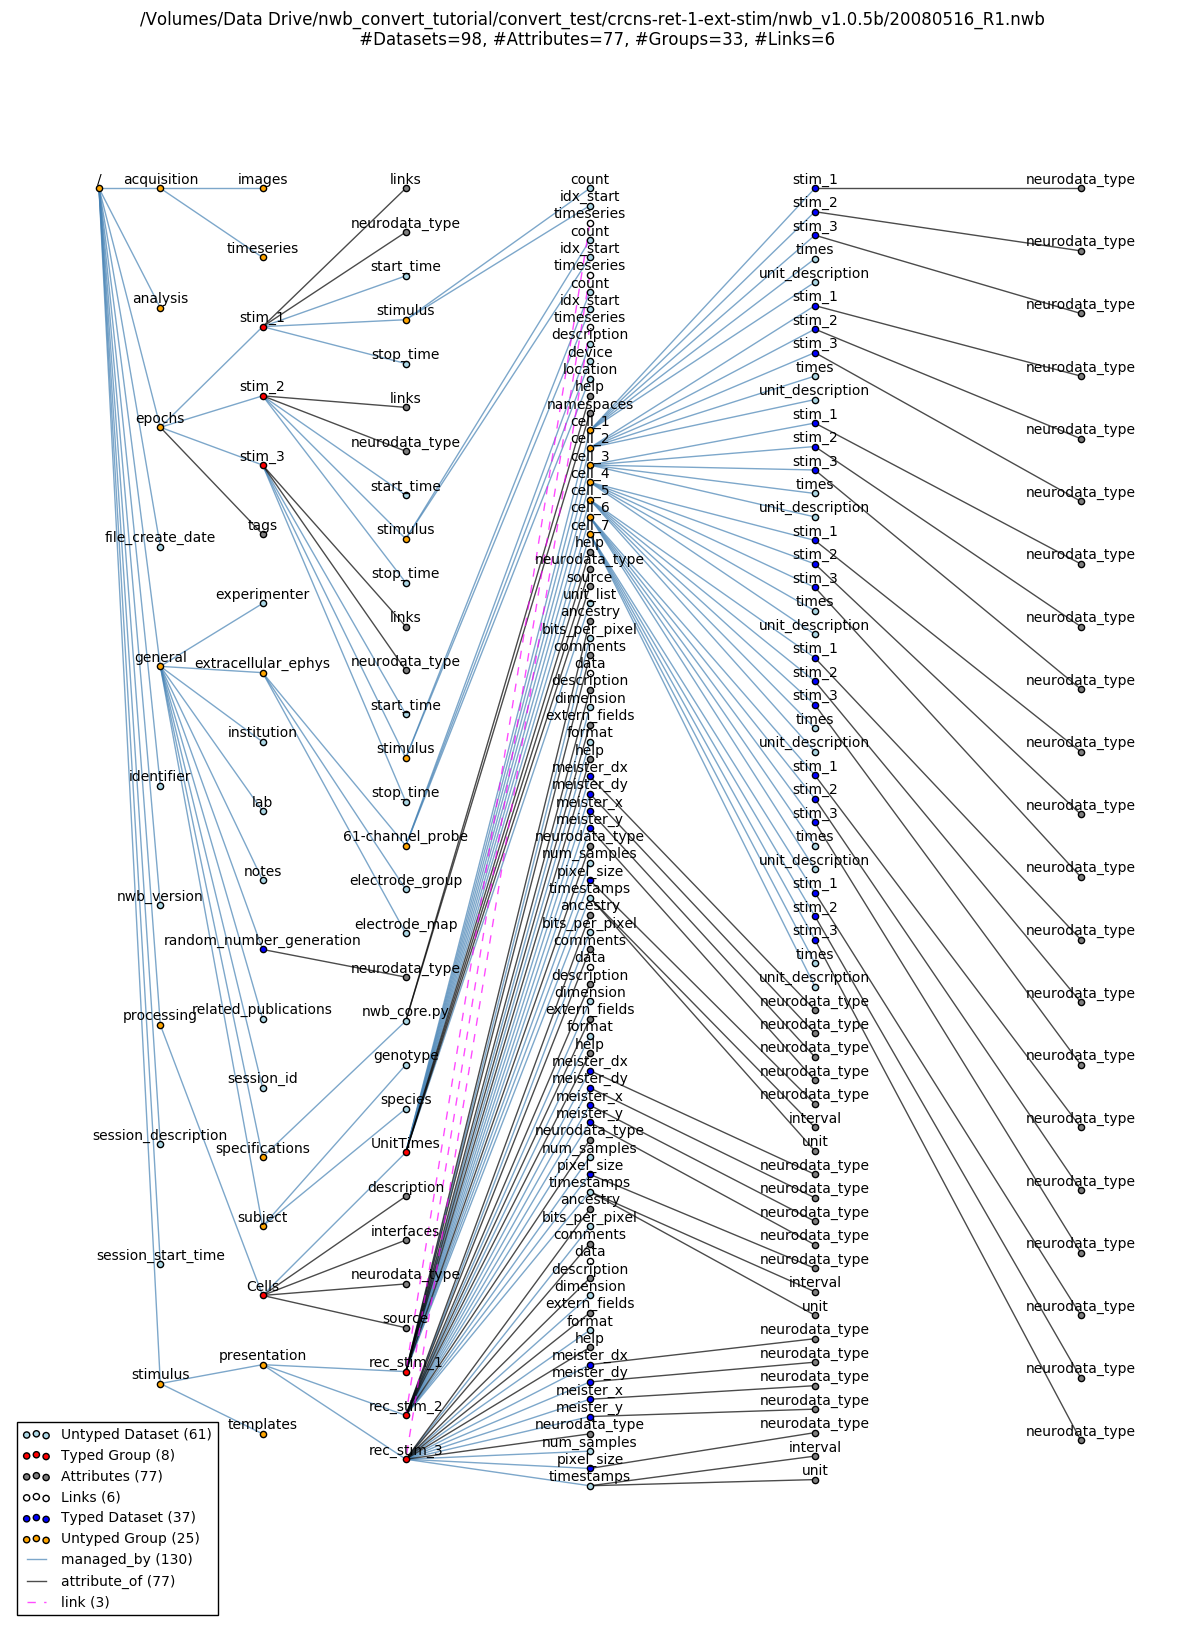

In [22]:
if VIS_AVAILABLE:
    show_bar_plot = False
    output_filenames = [fm['output_filename'] for fi, fm in per_file_meta.items()]
    #print(output_filenames)
    filenames = [pynwb_example_file, h5gate_example_file]
    #filenames = output_filenames
    for filename in filenames:
        file_hierarchy = HierarchyDescription.from_hdf5(filename)  
        file_graph = NXGraphHierarchyDescription(file_hierarchy)          
        fig = file_graph.draw(show_plot=False,
                              figsize=(12,16),
                              label_offset=(0.0, 0.0065),
                              label_font_size=10)
        plot_title = filename + " \n " + "#Datasets=%i, #Attributes=%i, #Groups=%i, #Links=%i" % (len(file_hierarchy['datasets']), len(file_hierarchy['attributes']), len(file_hierarchy['groups']), len(file_hierarchy['links']))
        plt.title(plot_title)
        plt.show()
        
        # Show a sorted bar plot with the sizes of all datasets in the file
        if show_bar_plot:
            print(filename)
            d = {i['name']: np.prod(i['size']) for i in file_hierarchy['datasets']}
            l = [w for w in sorted(d, key=d.get, reverse=True)]
            s = [d[w] for w in l]   
            p = np.arange(len(l))   
            fig,ax = plt.subplots(figsize=(16,7))
            ax.bar(p, s, width=1, color='r')
            ax.set_xticks(p+1)  
            ax.set_xticklabels(l)  
            fig.autofmt_xdate(bottom=0.2, rotation=90, ha='right')
            plt.show()
        